In [8]:
# Install: pip install scikit-image from terminal
from skimage import draw, transform
from skimage.transform import hough_line, probabilistic_hough_line, rotate
from scipy import ndimage
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [9]:
# Parameters
x0, y0 = 0.0, 2.0
angle_deg = 45

table_size = 10        # 10x10 table
max_hits = 100         # Max bounces to simulate
tol = 1e-9             # Tolerance for checking float equality

In [10]:
# Core logic for Period Count 
# Convert angle to radians and get initial velocity components
angle_rad = math.radians(angle_deg)
vx0 = math.cos(angle_rad)
vy0 = math.sin(angle_rad)

# Initialize current position and velocity
x, y = x0, y0
vx, vy = vx0, vy0

# Store trajectory for plotting
trajectory_x = [x]
trajectory_y = [y]

period_found = False
hits = 0

# Simulation loop
for i in range(max_hits):
    # Store the position at the beginning of this path segment
    x_prev, y_prev = x, y

    # Calculate time to hit vertical and horizontal walls
    t_to_x_wall = float('inf')
    if vx > 0:
        t_to_x_wall = (table_size - x) / vx
    elif vx < 0:
        t_to_x_wall = -x / vx

    t_to_y_wall = float('inf')
    if vy > 0:
        t_to_y_wall = (table_size - y) / vy
    elif vy < 0:
        t_to_y_wall = -y / vy
   
    t = min(t_to_x_wall, t_to_y_wall)
   
    # Move ball to the wall for the next bounce
    x += vx * t
    y += vy * t
   
    # Check if the path segment crossed the start point
    # Only consider it a valid return if the ball has hit at least 2 walls
    if hits >= 2:
        cross_product = (y0 - y_prev) * (x - x_prev) - (y - y_prev) * (x0 - x_prev)
        is_collinear = abs(cross_product) < tol

        is_within_x = (min(x_prev, x) - tol) <= x0 <= (max(x_prev, x) + tol)
        is_within_y = (min(y_prev, y) - tol) <= y0 <= (max(y_prev, y) + tol)

        if is_collinear and is_within_x and is_within_y:
            trajectory_x.append(x0)
            trajectory_y.append(y0)
            period_found = True
            
            # Add extra count for final path segment if either x0 or y0 equals 0
            # BUT NOT if the angle is straight vertical (90°, 270°) or horizontal (0°, 180°)
            is_straight_vertical = angle_deg % 180 == 90  # 90° or 270°
            is_straight_horizontal = angle_deg % 180 == 0  # 0° or 180°
            is_straight_shot = is_straight_vertical or is_straight_horizontal
            
            if (x0 == 0 or y0 == 0) and not is_straight_shot:
                hits += 1
        
            break
           
    # Add the bounce point to the trajectory
    trajectory_x.append(x)
    trajectory_y.append(y)
    hits += 1

    # Apply bounce logic for the next segment
    if abs(x - table_size) < tol or abs(x - 0) < tol:
        vx *= -1
    if abs(y - table_size) < tol or abs(y - 0) < tol:
        vy *= -1

In [30]:
# Core logic for Symmetry Counter
def find_symmetries_simple(traj_x, traj_y, table_size, tolerance=0.1):
    """
    Improved symmetry detection for billiard trajectories.
    """
    symmetries = []
    
    # Convert to numpy arrays
    x_points = np.array(traj_x)
    y_points = np.array(traj_y)
    
    center = table_size / 2
    
    # Check for vertical symmetry (reflection about x = center)
    # Count how many points have reflections
    vertical_matches = 0
    for i in range(len(x_points)):
        x, y = x_points[i], y_points[i]
        reflected_x = 2 * center - x
        
        # Check if the reflected point exists in the trajectory
        distances = np.sqrt((x_points - reflected_x)**2 + (y_points - y)**2)
        if np.min(distances) <= tolerance:
            vertical_matches += 1
    
    # If most points have reflections, consider it symmetric
    if vertical_matches >= len(x_points) * 0.7:  # 70% threshold
        symmetries.append("vertical_reflection")
    
    # Check for horizontal symmetry (reflection about y = center)
    horizontal_matches = 0
    for i in range(len(x_points)):
        x, y = x_points[i], y_points[i]
        reflected_y = 2 * center - y
        
        distances = np.sqrt((x_points - x)**2 + (y_points - reflected_y)**2)
        if np.min(distances) <= tolerance:
            horizontal_matches += 1
    
    if horizontal_matches >= len(x_points) * 0.7:
        symmetries.append("horizontal_reflection")
    
    # Check for diagonal symmetry (reflection about y = x line)
    diagonal_matches = 0
    for i in range(len(x_points)):
        x, y = x_points[i], y_points[i]
        reflected_x, reflected_y = y, x
        
        distances = np.sqrt((x_points - reflected_x)**2 + (y_points - reflected_y)**2)
        if np.min(distances) <= tolerance:
            diagonal_matches += 1
    
    if diagonal_matches >= len(x_points) * 0.7:
        symmetries.append("diagonal_reflection")
    
    return symmetries

In [35]:
def find_symmetries_image_based(trajectory_x, trajectory_y, table_size, tolerance=0.05):
    """
    Use scikit-image to detect actual symmetries of the trajectory pattern
    """
    from skimage import draw, transform
    
    # Create a high-resolution binary image of the trajectory
    img_size = 500
    trajectory_img = np.zeros((img_size, img_size), dtype=np.uint8)
    
    # Scale trajectory points to image coordinates
    scale = (img_size - 1) / table_size
    x_scaled = (np.array(trajectory_x) * scale).astype(int)
    y_scaled = (np.array(trajectory_y) * scale).astype(int)
    
    # Draw trajectory lines
    for i in range(len(x_scaled) - 1):
        rr, cc = draw.line(y_scaled[i], x_scaled[i], y_scaled[i+1], x_scaled[i+1])
        valid_idx = (rr >= 0) & (rr < img_size) & (cc >= 0) & (cc < img_size)
        trajectory_img[rr[valid_idx], cc[valid_idx]] = 255
    
    symmetries = []
    center = img_size // 2
    
    # Check if image is identical after rotation (rotational symmetry)
    angles_to_test = [90, 180]
    
    for angle in angles_to_test:
        # Rotate the image around center
        rotated = transform.rotate(trajectory_img, angle, center=(center, center), preserve_range=True)
        rotated = rotated.astype(np.uint8)
        
        # Compare rotated image with ORIGINAL image
        diff = np.sum(np.abs(trajectory_img.astype(float) - rotated.astype(float)))
        similarity = 1 - (diff / (img_size * img_size * 255))
        
        print(f"Rotation {angle}° similarity to original: {similarity:.3f}")
        
        if similarity > (1 - tolerance):
            if angle == 90:
                symmetries.append("4-fold_rotational")
            elif angle == 180:
                symmetries.append("2-fold_rotational")
    
    # Check reflection symmetries
    # Main diagonal reflection
    transposed = trajectory_img.T
    diagonal_diff = np.sum(np.abs(trajectory_img.astype(float) - transposed.astype(float)))
    diagonal_similarity = 1 - (diagonal_diff / (img_size * img_size * 255))
    
    # Anti-diagonal reflection
    anti_diagonal = np.rot90(np.fliplr(trajectory_img))
    anti_diagonal_diff = np.sum(np.abs(trajectory_img.astype(float) - anti_diagonal.astype(float)))
    anti_diagonal_similarity = 1 - (anti_diagonal_diff / (img_size * img_size * 255))
    
    print(f"Reflection symmetries: Main diagonal={diagonal_similarity:.3f}, Anti-diagonal={anti_diagonal_similarity:.3f}")
    
    if diagonal_similarity > (1 - tolerance):
        symmetries.append("main_diagonal_reflection")
    if anti_diagonal_similarity > (1 - tolerance):
        symmetries.append("anti_diagonal_reflection")
    
    return symmetries

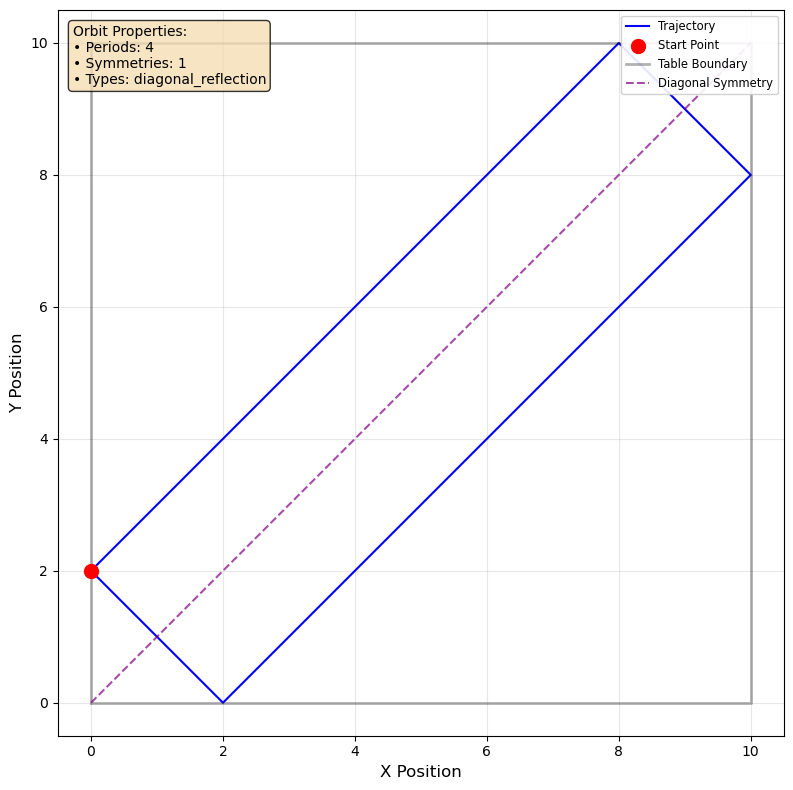

In [31]:
# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(trajectory_x, trajectory_y, '-', linewidth=1.5, label='Trajectory', color='blue')
plt.scatter([x0], [y0], color='red', s=100, zorder=5, label='Start Point')

# Add corner and edge markers for reference
corner_x = [0, table_size, table_size, 0, 0]
corner_y = [0, 0, table_size, table_size, 0]
plt.plot(corner_x, corner_y, 'k-', linewidth=2, alpha=0.3, label='Table Boundary')

# Add symmetry lines for visualization
center = table_size / 2
if "vertical_reflection" in symmetries:
    plt.axvline(x=center, color='green', linestyle='--', alpha=0.7, label='Vertical Symmetry')
if "horizontal_reflection" in symmetries:
    plt.axhline(y=center, color='orange', linestyle='--', alpha=0.7, label='Horizontal Symmetry')
if "diagonal_reflection" in symmetries:
    plt.plot([0, table_size], [0, table_size], 'purple', linestyle='--', alpha=0.7, label='Diagonal Symmetry')

plt.xlim(-0.5, table_size + 0.5)
plt.ylim(-0.5, table_size + 0.5)
plt.xlabel("X Position", fontsize=12)
plt.ylabel("Y Position", fontsize=12)

# Enhanced title with orbit information
counting_method = "Edge start" if (x0 == 0 or y0 == 0) else "Interior start"
symmetry_count = len(symmetries)
period_text = f"Periods: {hits}"
symmetry_text = f"Symmetries: {symmetry_count}"

plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize='small', framealpha=0.9)
plt.gca().set_aspect('equal', adjustable='box')

# Add text box with detailed information
info_text = f"Orbit Properties:\n• Periods: {hits}\n• Symmetries: {symmetry_count}\n• Types: {', '.join(symmetries) if symmetries else 'None'}"
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()